# Cohort Analysis (Retention)

First, we need to make sure that we have a dataset to work with. For testing purposes, we will need to make sure that several pieces of information are available to us:

* Customer ID, by which we can identify a unique user.
* Date of an event occurring (e.g. order placed)

Looking over [Kaggle](https://www.kaggle.com), I stumbled across a [dataset that shows superstore sales](https://www.kaggle.com/jr2ngb/superstore-data). This will work great!

To start, let's import the relevant references and read the CSV data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

working_dataframe = pd.read_csv('superstore-data.csv', encoding = 'ISO-8859-1')
working_dataframe.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.300,2,0.0,106.140,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.366,3,0.1,36.036,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.120,4,0.0,29.640,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.865,3,0.5,-26.055,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.670,5,0.1,37.770,4.70,Medium


For the purposes of this data experiment, we will remove all unrelated columns. Normally, one would likely want to test different cohorts to ensure that the data is representative of groups that potentially have different interests. For now, we'll focus on a consumer as a generic, uniform entity.

To drop columns, we can use the built-in `drop` function.

In [16]:
analysis_dataframe = working_dataframe[['Customer ID','Order Date']].copy()
analysis_dataframe.head()

,Customer ID,Order Date
0,TB-11280,1/1/2011
1,JH-15985,1/1/2011
2,AT-735,1/1/2011
3,EM-14140,1/1/2011
4,JH-15985,1/1/2011


We also need to [clean up the column names](https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd), to make sure that we are not dealing with spaces and other irregularities.

In [17]:
analysis_dataframe.columns = analysis_dataframe.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
analysis_dataframe.head()

,customer_id,order_date
0,TB-11280,1/1/2011
1,JH-15985,1/1/2011
2,AT-735,1/1/2011
3,EM-14140,1/1/2011
4,JH-15985,1/1/2011


In [18]:
analysis_dataframe.loc[:,'order_date'] = pd.to_datetime(analysis_dataframe.order_date)
analysis_dataframe.head()

,customer_id,order_date
0,TB-11280,2011-01-01
1,JH-15985,2011-01-01
2,AT-735,2011-01-01
3,EM-14140,2011-01-01
4,JH-15985,2011-01-01


In [19]:
analysis_dataframe.loc[:,'order_period'] = analysis_dataframe.order_date.apply(lambda x: x.strftime('%Y-%m'))

In [20]:
analysis_dataframe.head()

,customer_id,order_date,order_period
0,TB-11280,2011-01-01,2011-01
1,JH-15985,2011-01-01,2011-01
2,AT-735,2011-01-01,2011-01
3,EM-14140,2011-01-01,2011-01
4,JH-15985,2011-01-01,2011-01


In [21]:
analysis_dataframe.set_index('customer_id', inplace=True)

analysis_dataframe.loc[:, 'cohort'] = analysis_dataframe.groupby(level=0)['order_date'].min().apply(lambda x: x.strftime('%Y-%m'))
analysis_dataframe.reset_index(inplace=True)
analysis_dataframe.head()

,customer_id,order_date,order_period,cohort
0,TB-11280,2011-01-01,2011-01,2011-01
1,JH-15985,2011-01-01,2011-01,2011-01
2,AT-735,2011-01-01,2011-01,2011-01
3,EM-14140,2011-01-01,2011-01,2011-01
4,JH-15985,2011-01-01,2011-01,2011-01


In [8]:
grouped_cohort = analysis_dataframe.groupby(['cohort', 'order_period'])

cohorts = grouped_cohort.agg({'customer_id': pd.Series.nunique})

cohorts.rename(columns={'customer_id': 'total_users'}, inplace=True)
cohorts.head()

total_users
cohort  order_period             
2011-01 2011-01               266
        2011-02                58
        2011-03                77
        2011-04                62
        2011-05                56

In [9]:
def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

total_users  cohort_period
cohort  order_period                            
2011-01 2011-01               266              1
        2011-02                58              2
        2011-03                77              3
        2011-04                62              4
        2011-05                56              5

In [10]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort', 'cohort_period'], inplace=True)

cohort_group_size = cohorts['total_users'].groupby(level=0).first()
cohort_group_size.head()

cohort
2011-01    266
2011-02    165
2011-03    186
2011-04    125
2011-05    103
Name: total_users, dtype: int64

In [11]:
cohorts['total_users'].unstack(0).head()

cohort,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,...,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-10
cohort_period,,,,,,,,,,,,,,,,,,,,,
1,266.0,165.0,186.0,125.0,103.0,119.0,64.0,85.0,75.0,39.0,...,1.0,3.0,3.0,3.0,1.0,1.0,1.0,2.0,3.0,1.0
2,58.0,39.0,38.0,26.0,26.0,31.0,12.0,18.0,12.0,10.0,...,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,77.0,38.0,27.0,30.0,19.0,25.0,13.0,16.0,14.0,12.0,...,NaN,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN
4,62.0,39.0,53.0,31.0,33.0,35.0,18.0,17.0,16.0,6.0,...,NaN,1.0,2.0,1.0,NaN,NaN,1.0,1.0,1.0,NaN
5,56.0,55.0,37.0,28.0,29.0,19.0,17.0,15.0,10.0,3.0,...,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN


In [12]:
user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

cohort,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,...,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-10
cohort_period,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
2,0.218045,0.236364,0.204301,0.208,0.252427,0.260504,0.187500,0.211765,0.160000,0.256410,...,NaN,0.666667,0.333333,0.333333,1.0,1.0,1.0,0.5,0.333333,1.0
3,0.289474,0.230303,0.145161,0.240,0.184466,0.210084,0.203125,0.188235,0.186667,0.307692,...,NaN,0.333333,0.333333,0.333333,1.0,NaN,1.0,0.5,0.333333,NaN
4,0.233083,0.236364,0.284946,0.248,0.320388,0.294118,0.281250,0.200000,0.213333,0.153846,...,NaN,0.333333,0.666667,0.333333,NaN,NaN,1.0,0.5,0.333333,NaN
5,0.210526,0.333333,0.198925,0.224,0.281553,0.159664,0.265625,0.176471,0.133333,0.076923,...,NaN,0.333333,0.333333,0.333333,NaN,NaN,1.0,NaN,NaN,NaN
6,0.281955,0.175758,0.252688,0.296,0.233010,0.268908,0.296875,0.176471,0.093333,0.307692,...,NaN,0.666667,0.666667,0.333333,NaN,NaN,NaN,NaN,NaN,NaN
7,0.274436,0.254545,0.311828,0.272,0.281553,0.285714,0.109375,0.176471,0.133333,0.230769,...,NaN,NaN,NaN,0.666667,NaN,NaN,NaN,NaN,NaN,NaN
8,0.263158,0.278788,0.268817,0.264,0.271845,0.142857,0.156250,0.164706,0.120000,0.256410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.315789,0.254545,0.306452,0.320,0.203883,0.176471,0.250000,0.211765,0.186667,0.307692,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


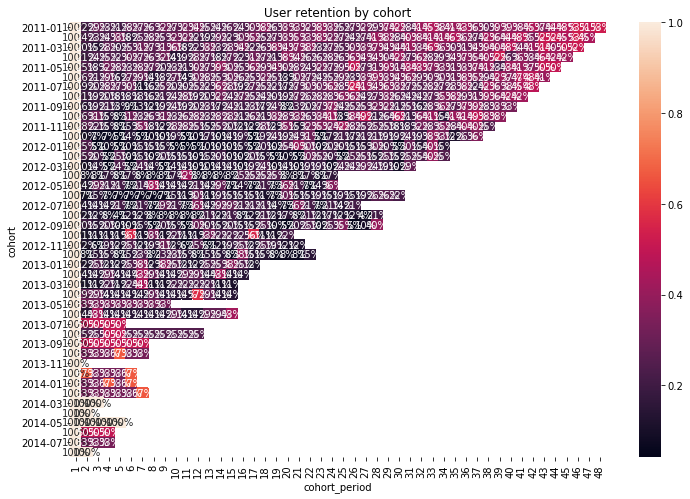

In [13]:
import seaborn as sns

plt.figure(figsize=(12, 8))
plt.title('User retention by cohort')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

The problem with the chart about is that it looks too far out, and clutters the view with irrelevant data. What we need to do is ensure that we select just the relevant data. Let's create a date constraint on the query.

In [14]:
# Set the baseline date limits.
import datetime
start_date = datetime.datetime(2013, 8, 1, 0, 0)
end_date = datetime.datetime(2014, 1, 1, 0, 0)

# Re-create the analysis dataframe.
analysis_dataframe = working_dataframe[['Customer ID','Order Date']]
analysis_dataframe.columns = analysis_dataframe.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
analysis_dataframe['order_date'] = pd.to_datetime(analysis_dataframe.order_date)

# Apply the mask and extract the relevant values.
mask = (analysis_dataframe['order_date'] > start_date) & (analysis_dataframe['order_date'] <= end_date)
target_dataframe = analysis_dataframe.loc[mask]

# Apply the order period.
target_dataframe['order_period'] = target_dataframe.order_date.apply(lambda x: x.strftime('%Y-%m'))

# Identify cohorts.
target_dataframe.set_index('customer_id', inplace=True)

target_dataframe['cohort'] = target_dataframe.groupby(level=0)['order_date'].min().apply(lambda x: x.strftime('%Y-%m'))
target_dataframe.reset_index(inplace=True)
target_dataframe.head()

grouped_cohort = target_dataframe.groupby(['cohort', 'order_period'])

cohorts = grouped_cohort.agg({'customer_id': pd.Series.nunique})

cohorts.rename(columns={'customer_id': 'total_users'}, inplace=True)

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

cohorts.reset_index(inplace=True)
cohorts.set_index(['cohort', 'cohort_period'], inplace=True)

cohort_group_size = cohorts['total_users'].groupby(level=0).first()

user_retention = cohorts['total_users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head()

/Users/targaryen/Documents/source/data-explorations/notebook_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/targaryen/Documents/source/data-explorations/notebook_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/Users/targaryen/Documents/source/data-explorations/notebook_env/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCo

cohort,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01
cohort_period,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.00,1.0
2,0.448343,0.358025,0.346667,0.264286,0.01,NaN
3,0.356725,0.410494,0.373333,0.007143,NaN,NaN
4,0.430799,0.382716,0.006667,NaN,NaN,NaN
5,0.434698,0.015432,NaN,NaN,NaN,NaN


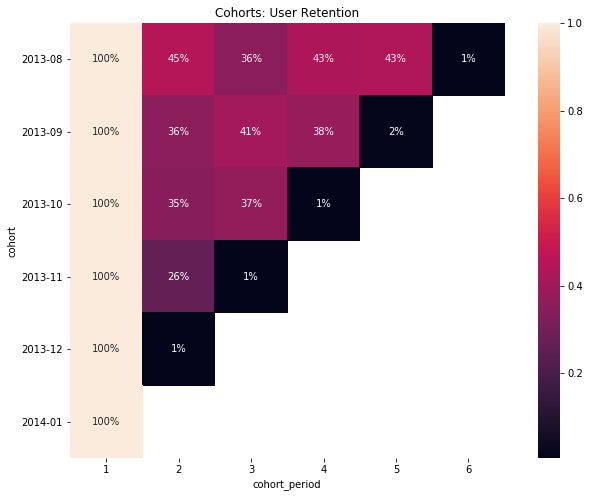

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', ax=ax, square=True);
plt.yticks(rotation=0)
plt.show()

Worth noting that using `matplotlib` 3.1.1 results in the plot being [clipped if there are Y-axis labels](https://github.com/mwaskom/seaborn/issues/1773). Therefore, it's important to downgrade `matplotlib` to 3.1.0. This can be done with:

```bash
pip uninstall matplotlib && pip install matplotlib==3.1.0
```

This should be addressed in 3.1.2.